In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DOWNLOAD FILE LIBRARY

In [2]:
!pip3 install vncorenlp
!pip install -q tf-models-official

     |████████████████████████████████| 2.7MB 27.6MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=9024d1699e418c421ad6475d7f1cc3c6d203c328529e4ec2478160d92b2161f5
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 1.6MB 26.3MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 358kB 37.1MB/s 
     |████████████████████████████████| 645kB 47.2MB/s 
     |████████████████████████████████| 38.2MB 71kB/s 
     |████████████████████████████████| 215kB 47.5MB/s 
     |████████████████████████████████| 686kB 36.2MB/s 
     |████████████████████████████████| 1.2MB 46.1MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 


In [3]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

In [4]:
# annotator = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

# def preprocessing(row):
#   def tokenizer(row):
#     row = annotator.tokenize(row)
#     return ' '.join([' '.join(words) for words in row])
#   return tokenizer(row)

# IMPORT LIBRARY AND PATH DATASET

In [5]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

import tensorflow as tf
# from transformers import TFAutoModel
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, GRU, TimeDistributed, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from official.nlp import optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions
from tensorflow.keras.optimizers import Adam

np.random.seed(7)

In [6]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSFC_sentiment/BiGRU/images')
MODEL_PATH = os.path.join(path_root, 'model/VSFC_sentiment/BiGRU')
name_model = 'VSFC_sent_BiGRU'

path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')
path_VSFC_train_sents = os.path.join(path_root, 'data/UIT-VSFC/train/sents.txt')
path_VSFC_train_sentiments = os.path.join(path_root, 'data/UIT-VSFC/train/sentiments.txt')
path_VSFC_train_topics = os.path.join(path_root, 'data/UIT-VSFC/train/topics.txt')

path_VSFC_test_sents = os.path.join(path_root, 'data/UIT-VSFC/test/sents.txt')
path_VSFC_test_sentiments = os.path.join(path_root, 'data/UIT-VSFC/test/sentiments.txt')
path_VSFC_test_topics = os.path.join(path_root, 'data/UIT-VSFC/test/topics.txt')

path_VSFC_dev_sents = os.path.join(path_root, 'data/UIT-VSFC/dev/sents.txt')
path_VSFC_dev_sentiments = os.path.join(path_root, 'data/UIT-VSFC/dev/sentiments.txt')
path_VSFC_dev_topics = os.path.join(path_root, 'data/UIT-VSFC/dev/topics.txt')

# DATA LOADER AND PREPROCESSING

In [7]:
def read_txt(path):
  with open(path, 'r', encoding='utf-8') as f:
    return [elem.replace('\n', '') for elem in f.readlines()]

df_train = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_train.loc[:, 'sents'] = read_txt(path_VSFC_train_sents)
df_train.loc[:, 'sentiments'] = read_txt(path_VSFC_train_sentiments)
df_train.loc[:, 'topics'] = read_txt(path_VSFC_train_topics)

df_test = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_test.loc[:, 'sents'] = read_txt(path_VSFC_test_sents)
df_test.loc[:, 'sentiments'] = read_txt(path_VSFC_test_sentiments)
df_test.loc[:, 'topics'] = read_txt(path_VSFC_test_topics)

df_dev = pd.DataFrame(columns=['sents', 'sentiments', 'topics'])
df_dev.loc[:, 'sents'] = read_txt(path_VSFC_dev_sents)
df_dev.loc[:, 'sentiments'] = read_txt(path_VSFC_dev_sentiments)
df_dev.loc[:, 'topics'] = read_txt(path_VSFC_dev_topics)


In [8]:
df_train = df_train.astype({"sentiments": "int", "topics": "int", 'sents': "string"})
df_test = df_test.astype({"sentiments": "int", "topics": "int", 'sents': "string"})
df_dev = df_dev.astype({"sentiments": "int", "topics": "int", 'sents': "string"})

In [9]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [10]:
df_train.loc[:, 'sents'] = df_train.loc[:, 'sents'].apply(preprocessing)
df_test.loc[:, 'sents'] = df_test.loc[:, 'sents'].apply(preprocessing)
df_dev.loc[:, 'sents'] = df_dev.loc[:, 'sents'].apply(preprocessing)

In [11]:
df_train.head(5)

,sents,sentiments,topics
0,slide giáo_trình đầy_đủ .,2,1
1,"nhiệt_tình giảng_dạy , gần_gũi với sinh_viên .",2,0
2,đi học đầy_đủ full điểm chuyên_cần .,0,1
3,chưa áp_dụng công_nghệ_thông_tin và các thiết_...,0,0
4,"thầy giảng bài hay , có nhiều bài_tập ví_dụ ng...",2,0


In [12]:
# Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [13]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 256
DROPOUT = 0.5
nclasses = len(df_train['sentiments'].unique())
EMBEDDING_DIM = 300
BATCH_SIZE = 128
EPOCH = 10
lr = 1e-3
STEPS_PER_EPOCH = len(df_train['sents']) // BATCH_SIZE
VALIDATION_STEPS = len(df_dev['sents']) // BATCH_SIZE

In [14]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['sents'])
word_index = tokenizer.word_index

In [15]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [16]:
X_train = prepare_input(df_train['sents'], tokenizer)
Y_train = np.array(df_train['sentiments'].tolist())

X_dev = prepare_input(df_dev['sents'], tokenizer)
Y_dev = np.array(df_dev['sentiments'].tolist())

In [17]:
# Create embedding matrix 
# def create_embedding(EMBEDDING_DIM, word_index, embedding_dict):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(EMBEDDING_DIM, word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_VSFC.npy'), embedding_matrix)

In [18]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_VSFC.npy'))

# Fine-tuning with TensorFlow

## Define the model

In [19]:
def create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, gru_node=32):
  model = Sequential()
  
  model.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True))
  
  model.add(Bidirectional(GRU(gru_node, return_sequences=True)))
  model.add(Bidirectional(GRU(gru_node)))
  model.add(Dropout(dropout))
  
  model.add(Dense(nclasses, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
  return model

## Optimizers

In [20]:
optimizer = 'adam'

## Callbacks

In [21]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    verbose = 1
)

## Training

In [22]:
model = create_model(word_index, embedding_matrix, optimizer, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, DROPOUT, 128)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 300)          745800    
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 256)          330240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,373,259
Trainable params: 1,373,259
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, Y_train,
                              validation_data=(X_dev, Y_dev),
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              callbacks = [
                                  early_stop_callback, 
                                  checkpoint_callback
                              ],
                              verbose=1)

Epoch 1/10
90/90 [==============================] - 22s 123ms/step - loss: 0.6471 - accuracy: 0.7172 - val_loss: 0.4053 - val_accuracy: 0.8585
Epoch 2/10
90/90 [==============================] - 10s 112ms/step - loss: 0.3244 - accuracy: 0.8884 - val_loss: 0.2808 - val_accuracy: 0.9040
Epoch 3/10
90/90 [==============================] - 10s 112ms/step - loss: 0.2693 - accuracy: 0.9130 - val_loss: 0.2650 - val_accuracy: 0.9097
Epoch 4/10
90/90 [==============================] - 10s 114ms/step - loss: 0.2396 - accuracy: 0.9212 - val_loss: 0.2585 - val_accuracy: 0.9166
Epoch 5/10
90/90 [==============================] - 10s 114ms/step - loss: 0.2178 - accuracy: 0.9296 - val_loss: 0.2613 - val_accuracy: 0.9128
Epoch 6/10
90/90 [==============================] - 10s 115ms/step - loss: 0.1931 - accuracy: 0.9399 - val_loss: 0.2785 - val_accuracy: 0.9116
Epoch 7/10
90/90 [==============================] - 10s 113ms/step - loss: 0.1736 - accuracy: 0.9435 - val_loss: 0.2470 - val_accuracy: 0.9160

# Predict on test data

In [24]:
X_test = prepare_input(df_test['sents'], tokenizer)
y_test = np.array(df_test['sentiments'].tolist())

In [25]:
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
metric = metrics.classification_report(y_test, y_pred, output_dict=True)
print(metrics.classification_report(y_test, y_pred, digits=4, target_names=['negative', 'neutral', 'positive']))


 Evaluating Model ... 

25/25 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

    negative     0.8774    0.9652    0.9192      1409
     neutral     0.5610    0.4132    0.4759       167
    positive     0.9545    0.8962    0.9244      1590

    accuracy                         0.9015      3166
   macro avg     0.7976    0.7582    0.7732      3166
weighted avg     0.8994    0.9015    0.8985      3166



In [26]:
f1 = round(metric['macro avg']['f1-score'], 4)
name_model_ = name_model + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.h5'
name_img_ = 'loss' + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
model.save_weights(os.path.join(MODEL_PATH, name_model_))

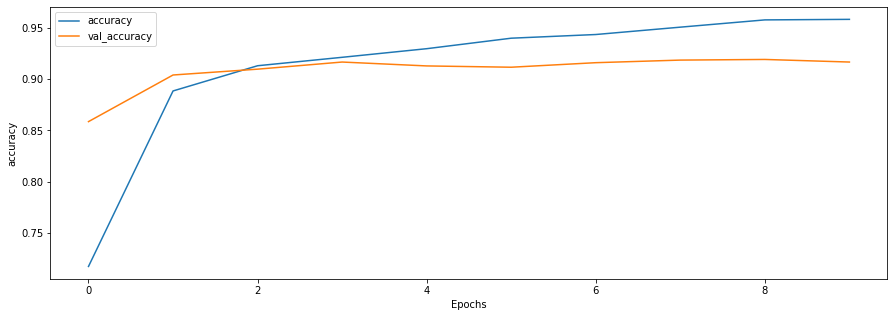

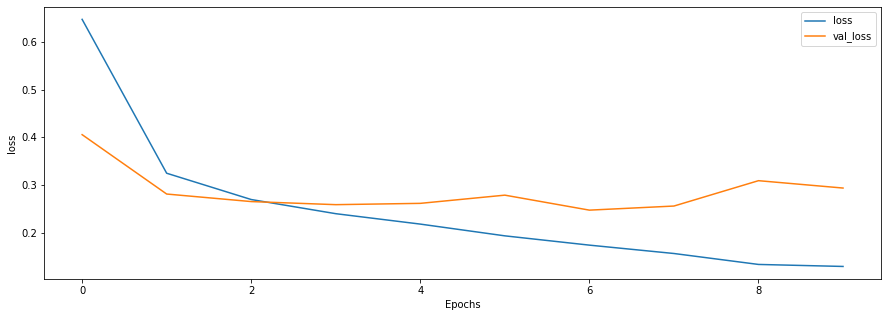

In [27]:
def plot_graphs(history, string):
  fig = plt.figure(figsize=(15, 5))
  name_img = string + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight') 
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

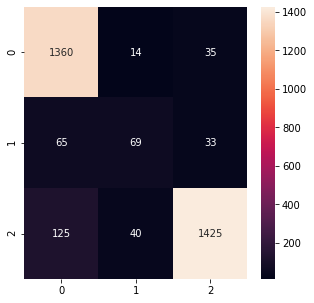

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(y_test, y_pred, metric, name_model)

In [29]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("BiGRU + Pho2WV:", f1_score(y_test, y_pred, average='micro'))
print("BiGRU + Pho2WV:", recall_score(y_test, y_pred, average='micro'))
print("BiGRU + Pho2WV:", precision_score(y_test, y_pred, average='micro'))

BiGRU + Pho2WV: 0.901452937460518
BiGRU + Pho2WV: 0.901452937460518
BiGRU + Pho2WV: 0.901452937460518
